#按照論文中敘述的CNN-LSTM模型
#研究主題：
##建立一個基於 CNN 與 LSTM 的深度學習混合模型，用於 網路入侵偵測系統（Intrusion Detection System, IDS）。

#研究動機與背景：
##傳統 IDS 主要使用簽章（Signature-Based）或簡單機器學習。

##對新型攻擊、零日攻擊（Zero-Day Attacks）無法準確偵測。

##深度學習可自動提取特徵，具備時序記憶與空間辨識能力。

##CNN 擅長抽取空間特徵；LSTM 擅長分析時間序列。

#模型架構：CNN-LSTM Hybrid:
##CNN 區塊：

##多個卷積層 (Conv1D) + 池化層 (MaxPooling1D)。

##每層加上 BatchNormalization 與 Dropout，減少過擬合與協變偏移。

##LSTM 區塊：

##使用 LSTM 層學習時間序列資料的長期依賴性。

##分類器：

##若為二分類，最後使用 Dense(1, activation='sigmoid')。

##若為多分類，使用 Dense(n_classes, activation='softmax')。

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, MaxPooling1D, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# Step 1：資料載入與預處理

In [2]:
df = pd.read_csv("interface_flows_3.csv", parse_dates=["bidirectional_first_seen_ms","bidirectional_last_seen_ms","src2dst_first_seen_ms","src2dst_last_seen_ms","dst2src_first_seen_ms","dst2src_last_seen_ms"])
#df = pd.read_csv("data_change.csv", parse_dates=["bidirectional_first_seen_ms","bidirectional_last_seen_ms","src2dst_first_seen_ms","src2dst_last_seen_ms","dst2src_first_seen_ms","dst2src_last_seen_ms"])

C:\Users\User\AppData\Local\Temp\ipykernel_38772\3968284566.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("interface_flows_3.csv", parse_dates=["bidirectional_first_seen_ms","bidirectional_last_seen_ms","src2dst_first_seen_ms","src2dst_last_seen_ms","dst2src_first_seen_ms","dst2src_last_seen_ms"])
C:\Users\User\AppData\Local\Temp\ipykernel_38772\3968284566.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("interface_flows_3.csv", parse_dates=["bidirectional_first_seen_ms","bidirectional_last_seen_ms","src2dst_first_seen_ms","src2dst_last_seen_ms","dst2src_first_seen_ms","dst2src_last_seen_ms"])
C:\Users\User\AppData\Local\Temp\ipykernel_38772\3968284566.py:1: UserWarnin

In [3]:
#df[['Source', 'Destination', *_]] = df['Flow ID'].str.split('-', expand=True)
df = df.sort_values("bidirectional_first_seen_ms")

In [4]:
df = df.drop(columns=["id",
                       "src_ip", 
                       "src_mac", 
                       "src_oui", 
                       "src_port", 
                       "dst_ip", 
                       "dst_mac",
                       "dst_oui",
                       "dst_port",
                       "protocol",
                       "ip_version",
                       "vlan_id",
                       "tunnel_id",
                       "bidirectional_first_seen_ms",
                       "bidirectional_last_seen_ms",
                       "src2dst_first_seen_ms",
                        "src2dst_last_seen_ms",
                        "dst2src_first_seen_ms",
                        "dst2src_last_seen_ms",
                        "application_name",
                        "application_category_name",
                        "application_is_guessed",
                        "requested_server_name",
                        "client_fingerprint",
                        "server_fingerprint",
                        "user_agent",
                        "content_type"
                       ], errors='ignore')



In [5]:
print(f"欄位數量: {len(df.columns)}")
print(df.columns.tolist())

欄位數量: 60
['expiration_id', 'bidirectional_duration_ms', 'bidirectional_packets', 'bidirectional_bytes', 'src2dst_duration_ms', 'src2dst_packets', 'src2dst_bytes', 'dst2src_duration_ms', 'dst2src_packets', 'dst2src_bytes', 'bidirectional_min_ps', 'bidirectional_mean_ps', 'bidirectional_stddev_ps', 'bidirectional_max_ps', 'src2dst_min_ps', 'src2dst_mean_ps', 'src2dst_stddev_ps', 'src2dst_max_ps', 'dst2src_min_ps', 'dst2src_mean_ps', 'dst2src_stddev_ps', 'dst2src_max_ps', 'bidirectional_min_piat_ms', 'bidirectional_mean_piat_ms', 'bidirectional_stddev_piat_ms', 'bidirectional_max_piat_ms', 'src2dst_min_piat_ms', 'src2dst_mean_piat_ms', 'src2dst_stddev_piat_ms', 'src2dst_max_piat_ms', 'dst2src_min_piat_ms', 'dst2src_mean_piat_ms', 'dst2src_stddev_piat_ms', 'dst2src_max_piat_ms', 'bidirectional_syn_packets', 'bidirectional_cwr_packets', 'bidirectional_ece_packets', 'bidirectional_urg_packets', 'bidirectional_ack_packets', 'bidirectional_psh_packets', 'bidirectional_rst_packets', 'bidirectio

In [6]:
# Label encoding
le = LabelEncoder()
df['Label_encoded'] = le.fit_transform(df['Label'])

X = df.drop(columns=["Label", "Label_encoded"])
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
y = df['Label_encoded'].values

# === 2. 標準化與序列化（以時間為序列）===

In [7]:
scaler = StandardScaler()
# 特徵數可以試 50（論文提到是最佳）
k_best = SelectKBest(score_func=f_classif, k=20)
X_selected = k_best.fit_transform(X, y)
X_scaled = scaler.fit_transform(X_selected)

def create_sequences(X, y, window_size=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i+window_size])
        y_seq.append(y[i+window_size])  # 預測最後一筆
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y, window_size=10)

# 分割訓練與測試
split = int(0.7 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [35 36 37 43 44 45 51 52 53] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [8]:
import joblib
joblib.dump(k_best, 'kbest.save')
joblib.dump(scaler, 'scaler.save')

['scaler.save']

# === 3. CNN-LSTM 模型建立 ===

In [9]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))  # 第一層 LSTM return_sequences=True 才能接第二層
model.add(Dropout(0.2))

# 第二層
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(LSTM(32))  # 最後一層 LSTM 不需 return_sequences

# 最終分類層
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # 二分類

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# === 4. 訓練 ===

In [10]:
model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.1,
          callbacks=[EarlyStopping(monitor='val_loss', patience=2)], verbose=1)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8615 - loss: 0.4862 - val_accuracy: 0.9739 - val_loss: 0.1604
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9742 - loss: 0.1033 - val_accuracy: 0.9831 - val_loss: 0.0858
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9756 - loss: 0.0947 - val_accuracy: 0.9838 - val_loss: 0.0794
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9814 - loss: 0.0763 - val_accuracy: 0.9838 - val_loss: 0.0808
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9802 - loss: 0.0775 - val_accuracy: 0.9838 - val_loss: 0.0796


In [11]:
model.save('cnn_lstm_model.h5')

# === 5. 評估 ===

191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

=== Classification Report (CNN-LSTM) ===
              precision    recall  f1-score   support

      normal       0.97      0.98      0.98      4655
   syn_flood       0.93      0.90      0.92      1428

    accuracy                           0.96      6083
   macro avg       0.95      0.94      0.95      6083
weighted avg       0.96      0.96      0.96      6083



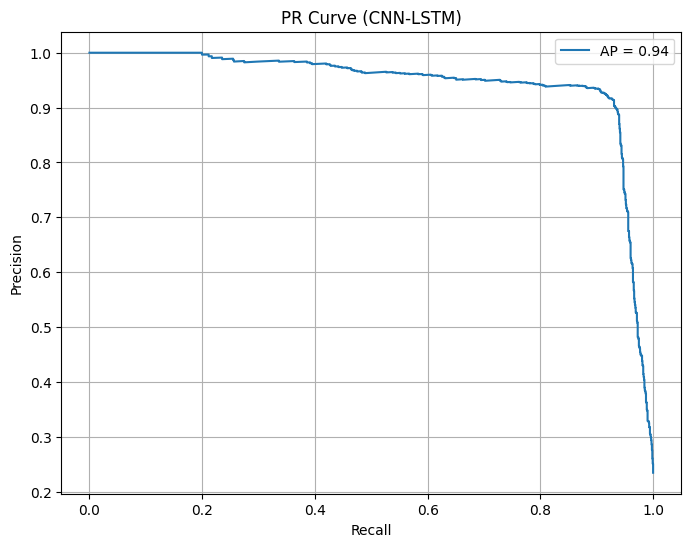

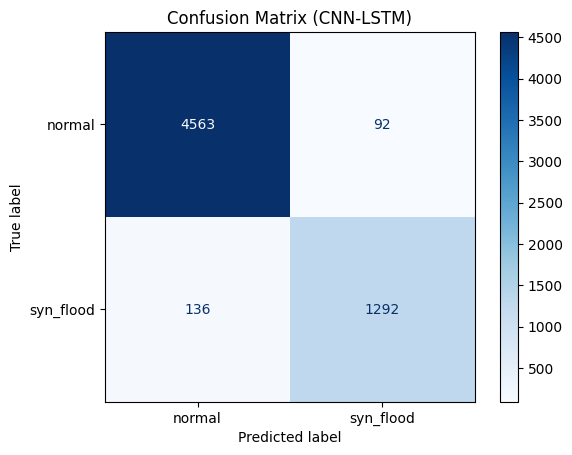

In [12]:
y_prob = model.predict(X_test).ravel()
y_pred = (y_prob > 0.5).astype(int)

print("\n=== Classification Report (CNN-LSTM) ===")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# PR Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
ap = average_precision_score(y_test, y_prob)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, label=f'AP = {ap:.2f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve (CNN-LSTM)")
plt.grid()
plt.legend()
plt.show()


#confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (CNN-LSTM)")
plt.show()
